In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sp
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 1. Reading and data extraction

In [139]:
df = pd.read_csv('../extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [140]:
# Resampling of the dataset over day

price_mean = df.price.resample('D').mean()
demand_sum = df.demand.resample('D').sum()
emissions_sum = df.emissions.resample('D').sum()

df_per_day = pd.DataFrame()

df_per_day['price_mean'] = price_mean
df_per_day['demand_sum'] = demand_sum
df_per_day['emissions_sum'] = emissions_sum

df_per_day.head()

,price_mean,demand_sum,emissions_sum
data,,,
2017-01-01,51.090833,562674,311397.3065
2017-01-02,60.201250,692927,348106.9305
2017-01-03,65.605833,747787,408527.3310
2017-01-04,66.288333,743568,402884.0675
2017-01-05,64.777083,711455,372642.2935


<AxesSubplot:title={'center':'Mean of the price resampled over day'}, xlabel='data'>

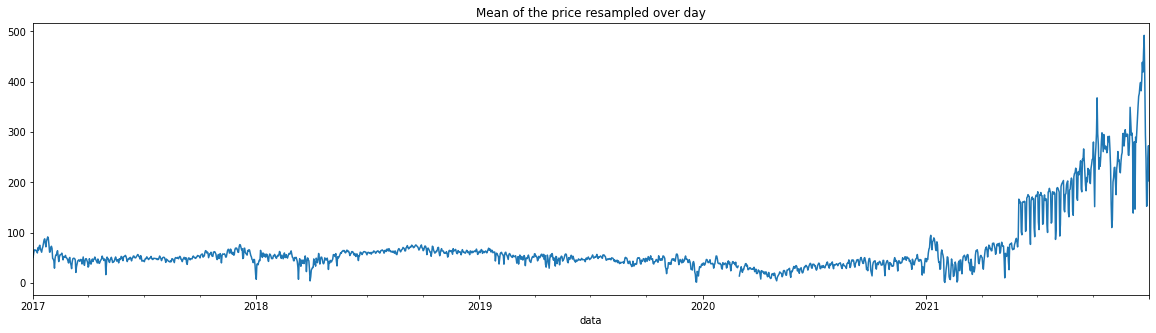

In [141]:
plt.figure(figsize=(20, 5))
df_per_day['price_mean'].plot(title='Mean of the price resampled over day')

<AxesSubplot:title={'center':'Sum of the demand resampled over day'}, xlabel='data'>

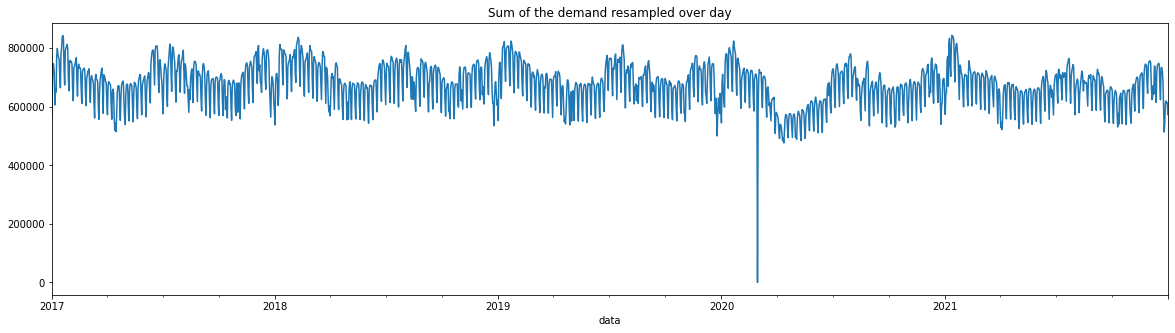

In [142]:
plt.figure(figsize=(20, 5))
df_per_day['demand_sum'].plot(title='Sum of the demand resampled over day')

<AxesSubplot:title={'center':'Sum of the emissions resampled over day'}, xlabel='data'>

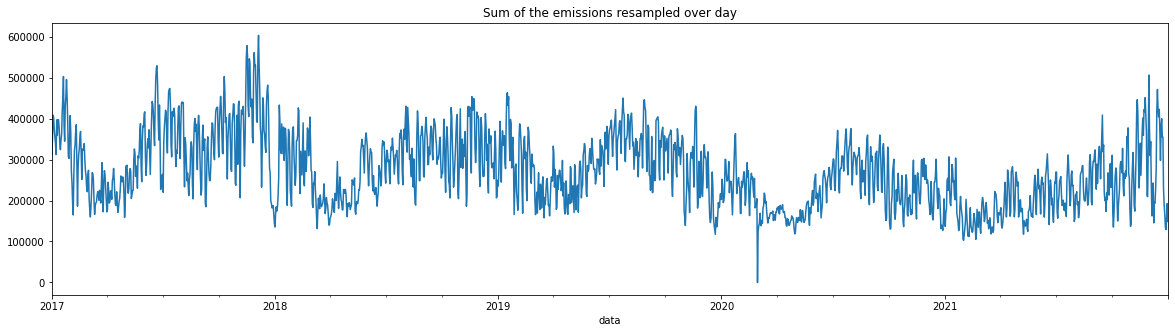

In [143]:
plt.figure(figsize=(20, 5))
df_per_day['emissions_sum'].plot(title='Sum of the emissions resampled over day')

<AxesSubplot:>

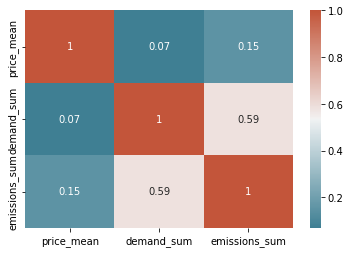

In [144]:
# Correlation matrix
MC = df_per_day.corr()
color_pattern = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(MC, annot=True, cmap=color_pattern)

# Se observa que no hay atributos derivados
# Y que cuando sube la demanda, suben las emisiones, ya que se encuentran bastante correlacionados

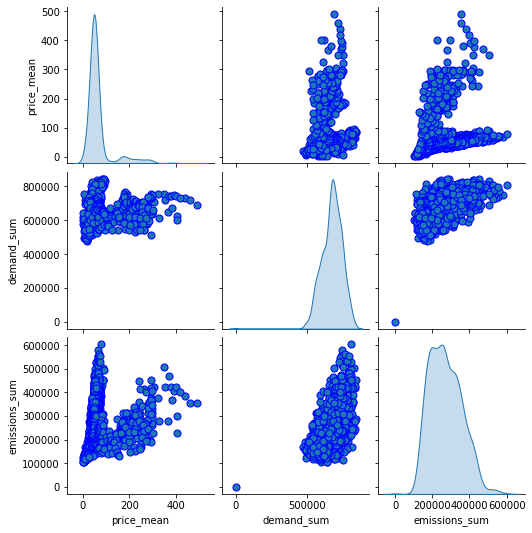

In [145]:
# Pairplot analysis for attributes
sns.pairplot(df_per_day, diag_kind="kde", plot_kws=dict(s=50, edgecolor="b", linewidth=1), diag_kws=dict(shade=True))

# Todo lo que depende del precio tiene dos distribuciones, la de antes de la gran subida de precio y la de después,
# por eso se pueden observar dos distribuciones mezcladas

# En cuanto a las emisiones y la demanda, se puede observar una correlación entre los datos

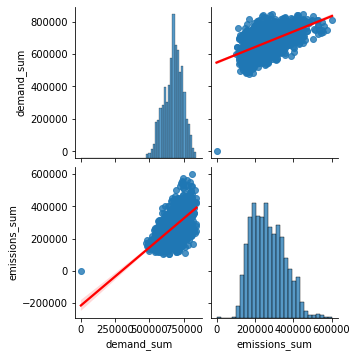

In [146]:
sns.pairplot(df_per_day.drop(columns='price_mean'), kind="reg", plot_kws={'line_kws':{'color':'red'}})

# Se puede observar mediante la recta de regresión la alta correlación entre la demanda y las emisiones

# 2. Demand

In [147]:
# Delete outliers
df_per_day['demand_sum'].replace(0, np.nan, inplace=True)
df_per_day['demand_sum'] = df_per_day['demand_sum'].interpolate()

## 2.1. Descriptive statistics

In [148]:
df_per_day['demand_sum'].describe()

count      1826.000000
mean     676528.297371
std       68778.704005
min      476483.000000
25%      629360.750000
50%      680279.000000
75%      726611.000000
max      844196.000000
Name: demand_sum, dtype: float64

## 2.2. Seasonality

In [149]:
# Seasonal decomposition
seasonal_decomposition = seasonal_decompose(df_per_day['demand_sum'], model='multiplicative', period=365)

<AxesSubplot:xlabel='data'>

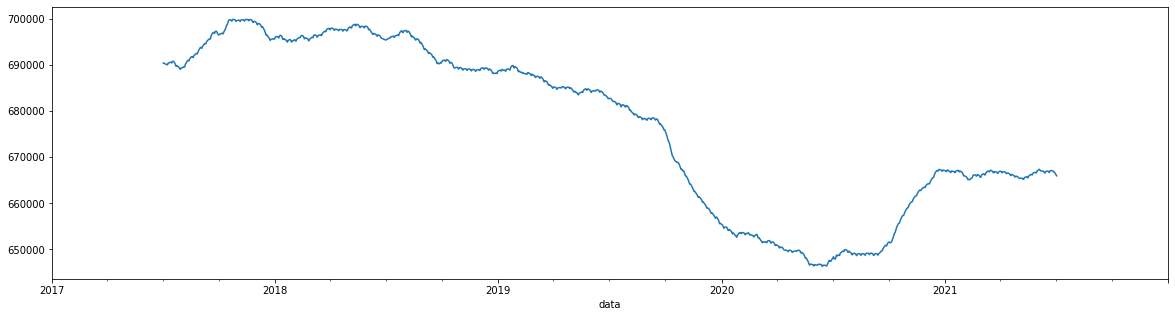

In [150]:
# Trend
demand_trend = seasonal_decomposition.trend
plt.figure(figsize=(20, 5))
demand_trend.plot()

# Hay menos demanda en el 2020 y se recupera en el 2021

<AxesSubplot:xlabel='data'>

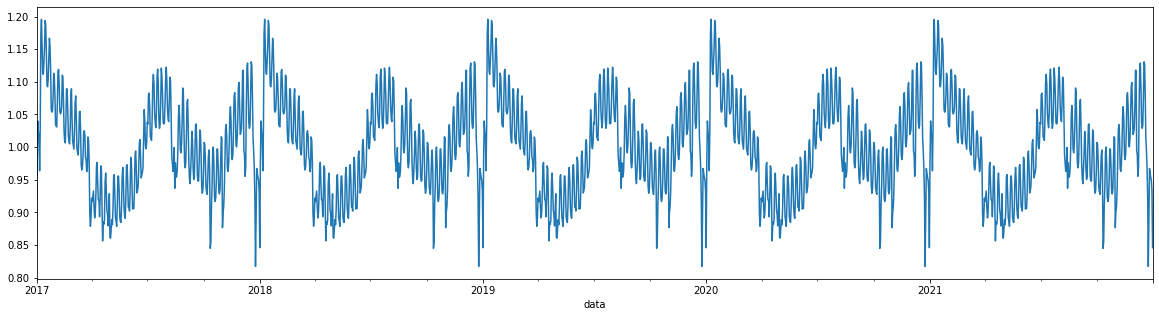

In [151]:
# Seasonality
demand_seasonality = seasonal_decomposition.seasonal
plt.figure(figsize=(20, 5))
demand_seasonality.plot()

<AxesSubplot:xlabel='data'>

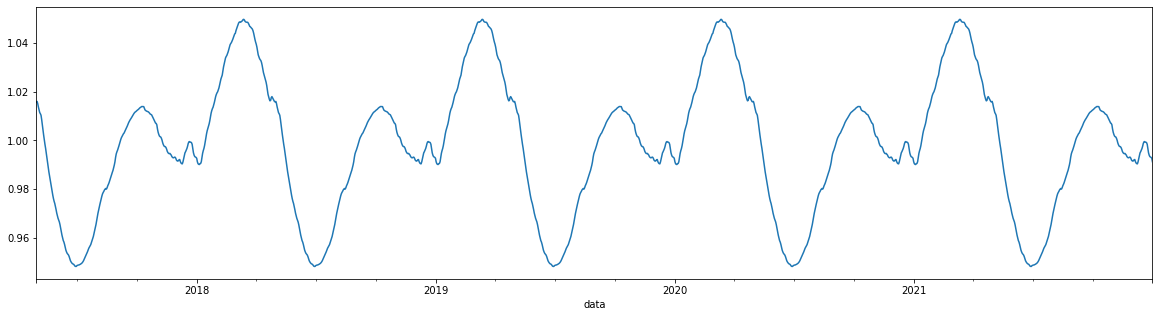

In [152]:
# Cycle length

# Data smoothing 
demand_seasons_denoised = demand_seasonality.rolling(120).mean() # Ventana temporal
demand_seasons_denoised.dropna(inplace=True)

plt.figure(figsize=(20, 5))
demand_seasons_denoised.plot()

# Se realiza un suavizado de los datos de la periodicidad de la demanda para encontrar máximos locales, 
# ya que lo que se pretende es calcular el tamaño del ciclo

In [153]:
# Encuentra los máximos locales en la gráfica
mean = np.mean(demand_seasons_denoised)
local_maxima, _ = sp.find_peaks(demand_seasons_denoised, height=1.01, distance=50)
differences = [(local_maxima[i]-local_maxima[i-1]) for i in range(1, len(local_maxima))]
np.mean(differences) 

# Se han eliminado los máximos locales que no aportan información, por lo que el número de máximos locales realmente
# es 2 por ciclo. Dicho ciclo se repite cada 180 días aproximadamente

180.22222222222223

# 3. Emissions

In [154]:
# Delete outliers
df_per_day['emissions_sum'].replace(0, np.nan, inplace=True)
df_per_day['emissions_sum'] = df_per_day['emissions_sum'].interpolate()

## 3.1. Descriptive statistics

In [155]:
df_per_day['emissions_sum'].describe()

count      1826.000000
mean     271069.004574
std       86458.864161
min      102803.882000
25%      200738.758625
50%      261689.841500
75%      332001.533875
max      603066.465500
Name: emissions_sum, dtype: float64

## 3.2. Seasonality

In [156]:
# Seasonal decomposition
seasonal_decomposition_em = seasonal_decompose(df_per_day['emissions_sum'], model='multiplicative', period=365)

<AxesSubplot:xlabel='data'>

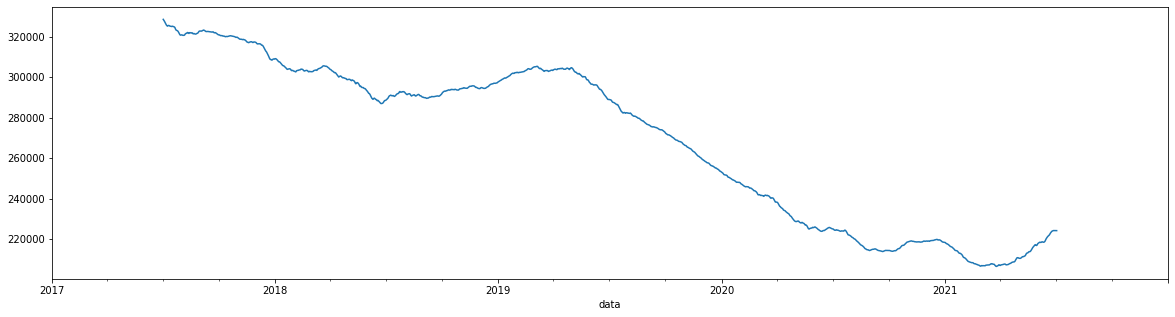

In [157]:
# Trend
emission_trend = seasonal_decomposition_em.trend
plt.figure(figsize=(20, 5))
emission_trend.plot()

# Las emisiones de CO2 obtienen los mejores resultados en 2021 con su mayor bajada de emision para los años presentados

<AxesSubplot:xlabel='data'>

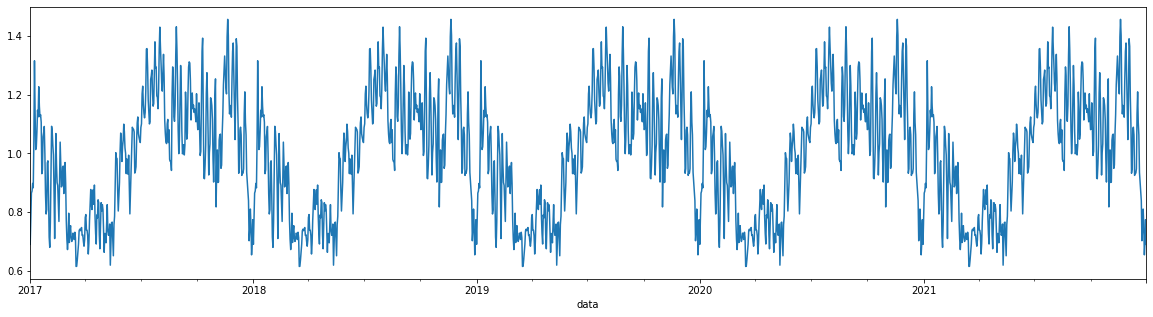

In [158]:
# Seasonality
emission_seasonality = seasonal_decomposition_em.seasonal
plt.figure(figsize=(20, 5))
emission_seasonality.plot()

<AxesSubplot:xlabel='data'>

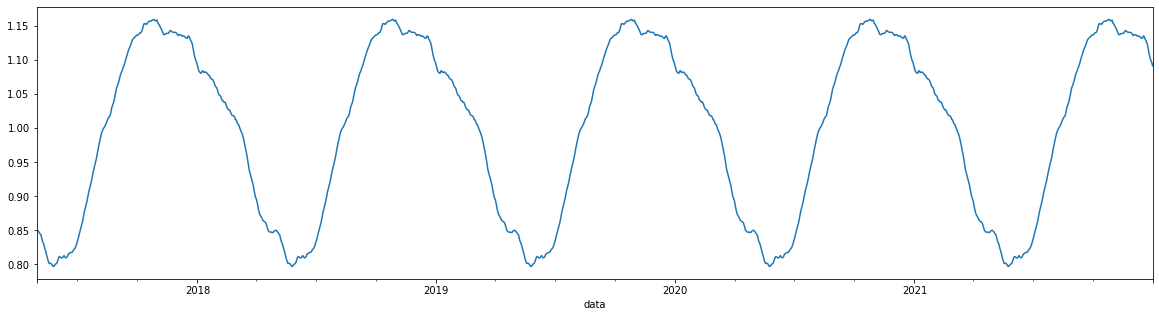

In [159]:
# Cycle length

# Data smoothing 
emission_seasons_denoised = emission_seasonality.rolling(120).mean() # Ventana temporal
emission_seasons_denoised.dropna(inplace=True)

plt.figure(figsize=(20, 5))
emission_seasons_denoised.plot()

# Se realiza un suavizado de los datos de la periodicidad de la emisión para encontrar máximos locales, 
# ya que lo que se pretende es calcular el tamaño del ciclo

In [160]:
# Encuentra los máximos locales en la gráfica
mean = np.mean(emission_seasons_denoised)
local_maxima_em, _ = sp.find_peaks(emission_seasons_denoised, height=1.01, distance=100)
differences_em = [(local_maxima_em[i]-local_maxima_em[i-1]) for i in range(1, len(local_maxima_em))]
np.mean(differences_em) 

# Se han eliminado los máximos locales que no aportan información, por lo que el número de máximos locales realmente
# es 2 por ciclo. Dicho ciclo se repite cada 180 días aproximadamente

182.5

# 4. Price

## 4.1. Descriptive statistics

In [161]:
df_per_day['price_mean'].describe()

count    1825.000000
mean       68.210698
std        61.615978
min         1.419583
25%        41.480417
50%        50.498333
75%        62.878750
max       491.952500
Name: price_mean, dtype: float64

## 4.2. Clustering

In [162]:
# Resampling of the dataset over day
price_mean_H = df.price.resample('H').mean()

# Delete outliers
price_mean_H.replace(0, np.nan, inplace=True)
price_mean_H = price_mean_H.interpolate()

In [163]:
# ravel baja el num de dimensiones a 1
series = price_mean_H.to_numpy().reshape(1, -1).ravel() 
# Tenemos 43824 datos con los que trabajar
len(series)

43824

In [171]:
# Numero de series temporales en las que vamos a dividir la serie grande
num_tseries = int(len(series)/249)
num_tseries

176

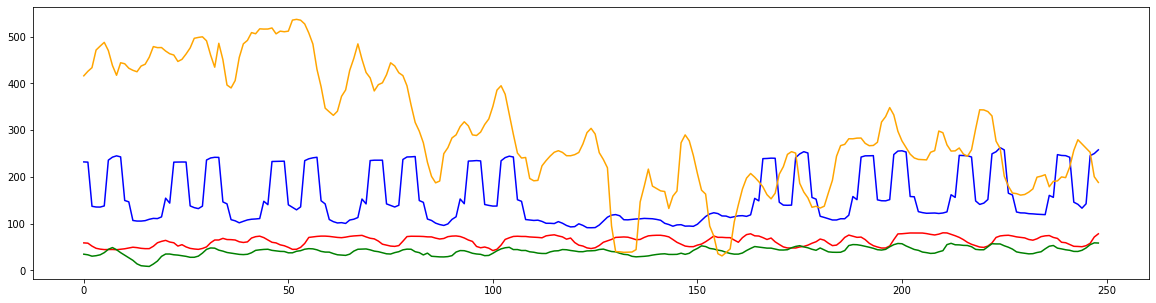

In [208]:
# Aquí se divide la serie temporal de precios en varias más pequeñas
divisions = np.array_split(series, num_tseries)
plt.figure(figsize=(20, 5))
plt.plot(divisions[0], c='red')
plt.plot(divisions[100], c='green')
plt.plot(divisions[-20], c='blue')
plt.plot(divisions[-1], c='orange')

In [173]:
price_kmeans = TimeSeriesKMeans(n_clusters=2, max_iter=100, metric='dtw')
p = price_kmeans.fit_predict(divisions)

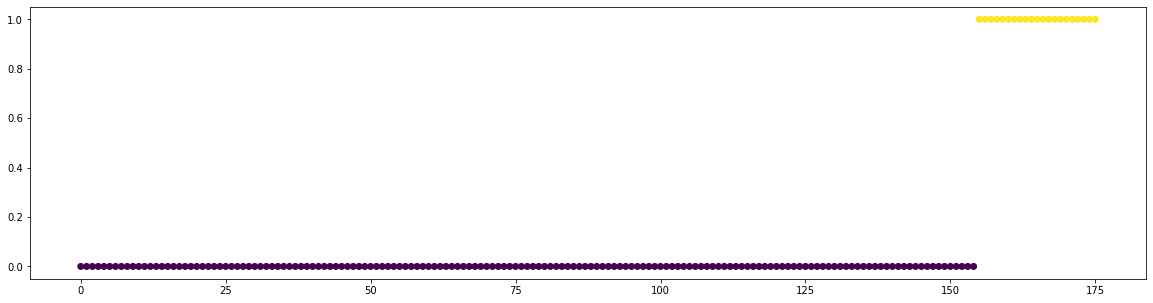

In [209]:
# Se observan dos clusters
data = pd.DataFrame({
    'x': list(range(len(p))),
    'y': p
})
plt.figure(figsize=(20, 5))
plt.scatter(data.x, data.y, c=data.y)

In [192]:
p

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [194]:
cluster_ranges = np.ravel([[i]*len(p) for i in p])
cluster_ranges

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [196]:
clustered_data = price_mean_H.to_frame()
clustered_data['cluster'] = cluster_ranges
print(clustered_data)

                      price  cluster
data                                
2017-01-01 00:00:00   58.82        0
2017-01-01 01:00:00   58.23        0
2017-01-01 02:00:00   51.95        0
2017-01-01 03:00:00   47.27        0
2017-01-01 04:00:00   45.49        0
...                     ...      ...
2021-12-31 19:00:00  270.54        1
2021-12-31 20:00:00  261.40        1
2021-12-31 21:00:00  252.43        1
2021-12-31 22:00:00  200.33        1
2021-12-31 23:00:00  188.09        1

[43824 rows x 2 columns]


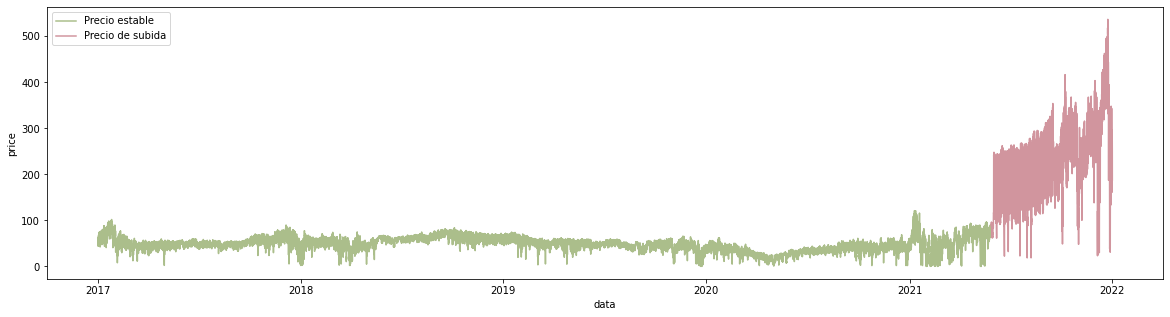

In [275]:
# Se observan dos clusters
palette = sns.cubehelix_palette(start=1, rot=6, dark=0.5, light=.70)
sns.set_palette(palette)
plt.figure(figsize=(20, 5))
plot = sns.lineplot(x=clustered_data.index, y=clustered_data.price, hue=clustered_data['cluster'])
plt.legend(labels=['Precio estable','Precio de subida'])
plt.show(plot)

<AxesSubplot:xlabel='data'>

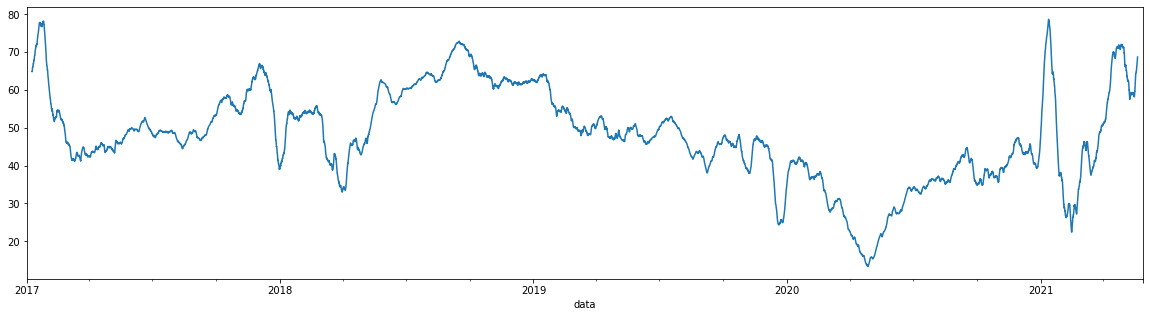

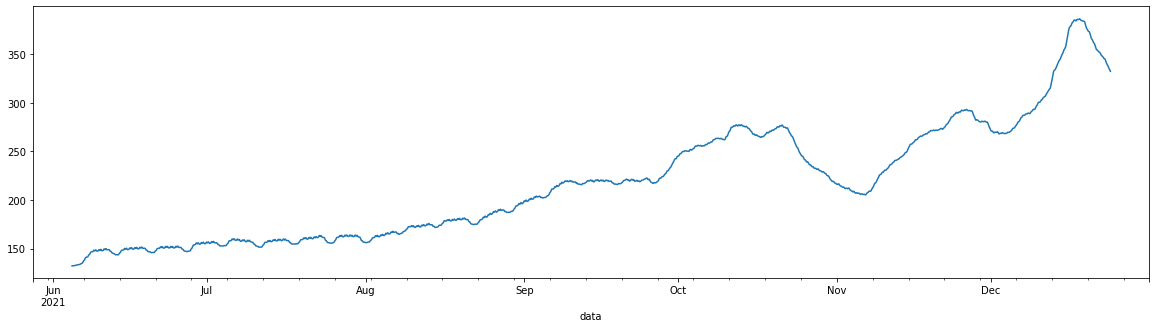

In [286]:
# Se calcula la trend para cada cluster

cluster1 = clustered_data['price'][clustered_data['cluster']==0]
cluster2 = clustered_data['price'][clustered_data['cluster']==1]

sns.set_palette('tab10')

# Cluster 1
# Seasonal decomposition
seasonal_decomposition_c1 = seasonal_decompose(cluster1, model='multiplicative', period=365)
# Trend
demand_trend_c1 = seasonal_decomposition_c1.trend
plt.figure(figsize=(20, 5))
demand_trend_c1.plot()

# Cluster 2
# Seasonal decomposition
seasonal_decomposition_c2 = seasonal_decompose(cluster2, model='multiplicative', period=365)
# Trend
demand_trend_c2 = seasonal_decomposition_c2.trend
plt.figure(figsize=(20, 5))
demand_trend_c2.plot()
